In [1]:
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
Using TensorFlow backend.


In [2]:
#Get the stock quote 
df = web.DataReader('RELIANCE.NS', data_source='yahoo', start='2015-06-16', end='2020-06-15') 
#Show the data 
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-06-16,452.500000,446.600006,449.500000,451.975006,6368010.0,434.441772
2015-06-17,471.174988,447.000000,452.524994,465.600006,11992678.0,447.538269
2015-06-18,491.000000,466.250000,466.274994,489.475006,22568840.0,470.487091
2015-06-19,503.200012,491.250000,491.250000,498.325012,20897502.0,478.993805
2015-06-22,504.350006,493.250000,498.475006,495.850006,8866370.0,476.614777
...,...,...,...,...,...,...
2020-06-10,1579.550049,1540.050049,1543.099976,1572.150024,10214213.0,1572.150024
2020-06-11,1567.949951,1531.000000,1566.000000,1537.699951,9408046.0,1537.699951
2020-06-12,1593.000000,1497.000000,1500.000000,1588.800049,17790311.0,1588.800049


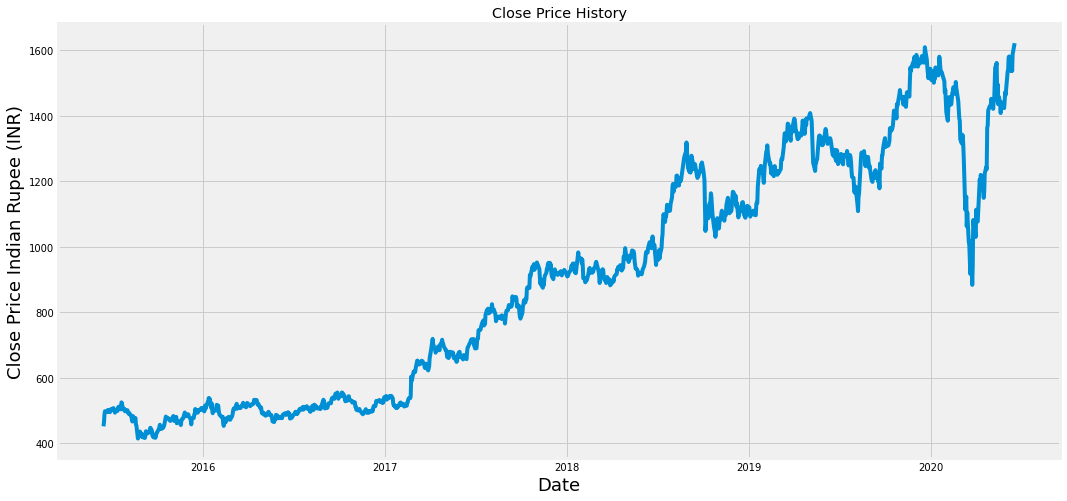

In [7]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price Indian Rupee (INR)',fontsize=18)
plt.show()

In [0]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8) 

In [0]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [0]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [0]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [0]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [0]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [0]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [17]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
924/924 [==============================] - 36s 39ms/step - loss: 0.0020


In [0]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [0]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

In [0]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [0]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

In [22]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

88.35052655706644

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


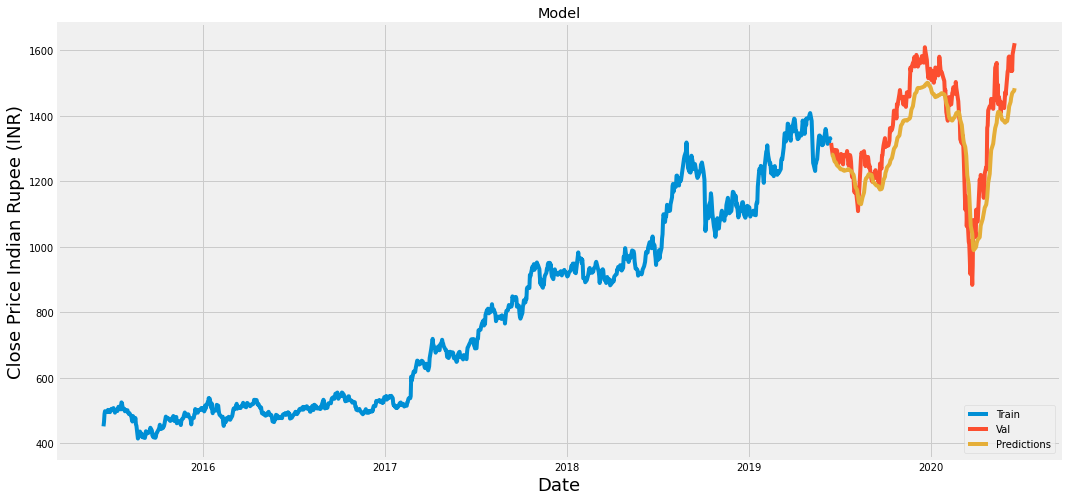

In [23]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Indian Rupee (INR)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [24]:
#Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2019-06-14,1317.550049,1282.608398
2019-06-17,1282.300049,1281.441284
2019-06-18,1281.000000,1277.040771
2019-06-19,1277.349976,1271.381348
2019-06-20,1296.750000,1265.267456
...,...,...
2020-06-10,1572.150024,1462.206909
2020-06-11,1537.699951,1468.920166
2020-06-12,1588.800049,1471.825806


In [26]:
#Get the quote
reliance_quote = web.DataReader('RELIANCE.NS', data_source='yahoo', start='2015-06-16', end='2020-06-15')
#Create a new dataframe
new_df = reliance_quote.filter(['Close'])
#Get teh last 60 day closing price 
last_60_days = new_df[-60:].values
#Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
#Create an empty list
X_test = []
#Append teh past 60 days
X_test.append(last_60_days_scaled)
#Convert the X_test data set to a numpy array
X_test = np.array(X_test)
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#Get the predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling 
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[1493.2745]]


In [27]:
#Get the quote
reliance_quote2 = web.DataReader('RELIANCE.NS', data_source='yahoo', start='2015-06-16', end='2020-06-15')
print(reliance_quote2['Close'])

Date
2015-06-16     451.975006
2015-06-17     465.600006
2015-06-18     489.475006
2015-06-19     498.325012
2015-06-22     495.850006
                 ...     
2020-06-10    1572.150024
2020-06-11    1537.699951
2020-06-12    1588.800049
2020-06-15    1614.550049
2020-06-16    1617.949951
Name: Close, Length: 1229, dtype: float64


Reference - https://medium.com/@randerson112358/stock-price-prediction-using-python-machine-learning-e82a039ac2bb